In [1]:
# import library
# ========= choice of library ====
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [40]:
# Get the certain STL 10 Data
from skimage import util 
data_location = "../../Dataset/STL10/img/2/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))

image_resize_px = 64
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index],mode='L'),(image_resize_px,image_resize_px))

# print out the data shape and the max and min value
train_batch = np.expand_dims(train_batch,3)
print('Train batch, min, max : ',train_batch.shape,train_batch.min(),train_batch.max())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Train batch, min, max :  (500, 64, 64, 1) 0.0 1.0


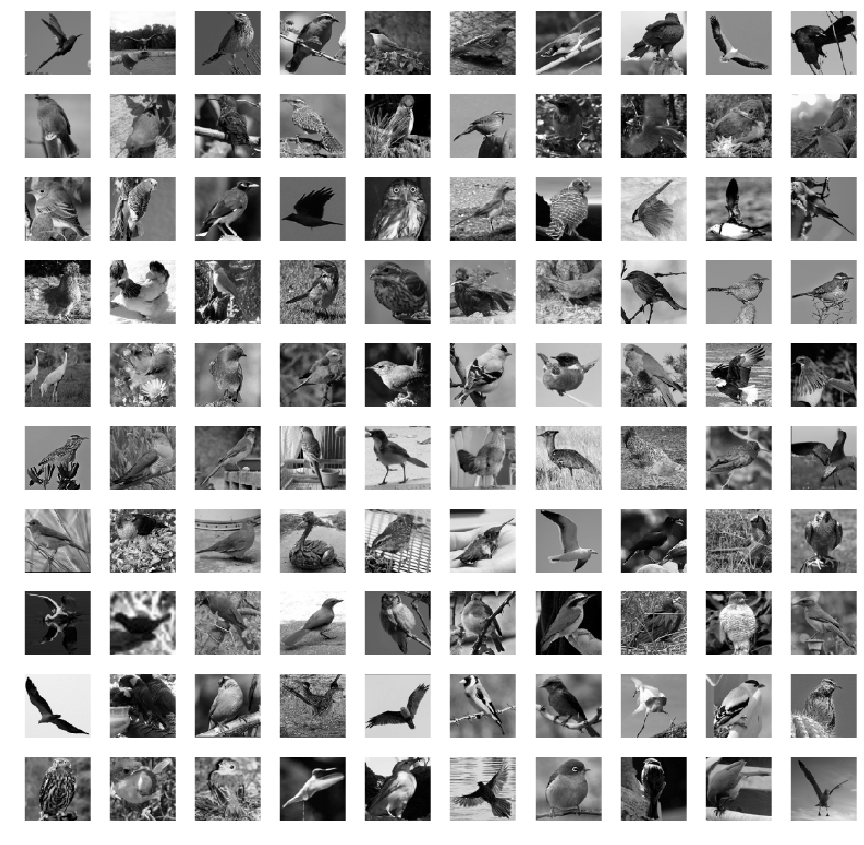

In [41]:
# view random 100 images
idx = np.random.permutation(len(train_batch))
train_batch = train_batch[idx]
fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
plt.show()

In [484]:
# layers
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float64)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float64) * x) + 1.0)
def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)
def tf_tanh(x): return tf.tanh(x)
def d_tf_tanh(x): return 1.0 - tf_tanh(x) ** 2
def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

class CNN():

    def __init__(self,k,inc,out,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='SAME',l2_reg = False):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        ) / batch_size

        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        )

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))

        return grad_pass,update_w
    
class tf_pca_layer():
    
    def __init__(self,n_components):
        self.n_components = tf.Variable(n_components)
    
    def feedforward(self,input):
        self.input = input
        self.cov = tf.matmul(self.input,tf.transpose(self.input)) / (input.shape[0].value-1)
        self.eigval,self.pc = tf.linalg.eigh(self.cov)
        self.pc_projection = self.pc[:,-self.n_components:]
        self.layer = tf.matmul(tf.transpose(self.pc_projection),input)
        return self.layer
    
    def backprop(self,grad):
        mat_shape = self.input.shape[0].value
        d_pc_project = tf.transpose(tf.matmul(grad,tf.transpose(self.input)))
        diff = mat_shape - self.n_components
        added_mat = tf.zeros([mat_shape,diff],dtype=tf.float64)
        d_pc = tf.concat([d_pc_project,added_mat],1)
        
        E = tf.matmul(tf.ones([mat_shape,1],dtype=tf.float64),tf.transpose(self.eigval)[tf.newaxis,:]) - \
            tf.matmul(self.eigval[:,tf.newaxis],tf.ones([1,mat_shape],dtype=tf.float64))
        F = 1.0/(E + tf.eye(mat_shape,dtype=tf.float64)) - tf.eye(mat_shape,dtype=tf.float64)
        d_cov = tf.matmul(tf.linalg.inv(tf.transpose(self.pc)),
                tf.matmul(F * (tf.matmul(tf.transpose(self.pc),d_pc)),tf.transpose(self.pc)))
        
        d_x = tf.matmul(self.pc_projection,grad) + \
              (tf.matmul(d_cov,self.input) + tf.matmul(tf.transpose(d_cov),self.input))/(mat_shape-1)
        
        return d_x
    
class FastICA_Layer():
    """Performs ICA via FastICA method

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    outc : type
        Description of parameter `outc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    sym_decorrelation : type
        Description of attribute `sym_decorrelation`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    self,matrix : type
        Description of attribute `self,matrix`.
    act
    d_act

    """

    def __init__(self,inc,outc,act,d_act):
        self.w = tf.Variable(self.sym_decorrelation(tf.random_normal(shape=[inc,outc],stddev=0.05,dtype=tf.float64,seed=2)))
        self.m = tf.Variable(tf.zeros_like(self.w)) ; self.v = tf.Variable(tf.zeros_like(self.w))
        self.act = act; self.d_act = d_act

    def sym_decorrelation(self,matrix):
        s, u = tf.linalg.eigh(tf.matmul(matrix,tf.transpose(matrix)))
        decor_matrx = tf.matmul(u * (1.0/tf.sqrt(s)),tf.transpose(u))
        return tf.matmul(decor_matrx,matrix)

    def getw(self): return self.w

    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer

    def backprop_ica(self):
        self.layerA  = self.act(tf.matmul(self.w,self.input))
        self.layerDA = tf.reduce_mean(self.d_act(tf.matmul(self.w,self.input)),-1)
        grad_pass = tf.matmul(tf.transpose(self.w),self.layer)
        
        grad_w = tf.matmul(self.layerA,tf.transpose(self.input)) / self.input.shape[1].value - self.layerDA[:,tf.newaxis] * self.w
        grad = self.sym_decorrelation(grad_w)
        
        update_w = []
        
        # ==== Correct Method of Weight Update ====
        # update_w.append(tf.assign(self.w,grad))
        
        # ==== Wrong (gradient ascent) Method of Weight Update ====
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        
        return grad_pass,update_w
    
class tf_mean_layer():
    
    def __init__(self):
        pass
    
    def feedforward(self,input):
        self.mean = tf.reduce_mean(input,1)
        return input-self.mean[:,tf.newaxis]
    
    def backprop(self,grad):
        return grad * (1 + grad.shape[0].value)

In [485]:
# define hyper, class and graph
num_epcoch = 200 ; learning_rate = 0.003; print_size = 10
batch_size = 250
beta1,beta2,adam_e = 0.9,0.999,1e-8

l1 = CNN(3,1,1,act=tf_sigmoid,d_act=d_tf_sigmoid)
l2 = CNN(3,1,1,act=tf_sigmoid,d_act=d_tf_sigmoid)
pca_l = tf_pca_layer(20)
ica_l = FastICA_Layer(20,20,act=tf_tanh,d_act=d_tf_tanh)

x = tf.placeholder(shape=[batch_size,64,64,1],dtype=tf.float64)
layer1 = l1.feedforward(x)
layer2 = l2.feedforward(layer1) 
layer_flat = tf.reshape(layer2,[batch_size,-1])
pca_layer = pca_l.feedforward(layer_flat)
ica_layer = ica_l.feedforward(pca_layer)

grad_ica,grad_ica_up = ica_l.backprop_ica()
grad_pca = pca_l.backprop(grad_ica)
grad_pca_reshape = tf.reshape(grad_pca,[batch_size,64,64,1])
grad_2,grad_2_up = l2.backprop(grad_pca_reshape) 
grad_1,grad_1_up = l1.backprop(grad_2) 
grad_up = grad_ica_up + grad_2_up + grad_1_up

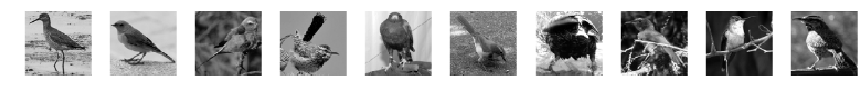

0 0.4112135463782076
0 0.4089063629883213
1 0.4030340778130251
1 0.3914744661269099
2 0.3824030333223194
2 0.37829240292743554
3 0.36874331175518116
3 0.3530594112348272
4 0.3486394680947103
4 0.3330046046634771
5 0.3276346093015425
5 0.31155085277570277
6 0.299518143725382
6 0.28818753037795897
7 0.27629028502754494
7 0.27018428742934947
8 0.253549886222319
8 0.24008776745852942
9 0.23295157094362046
9 0.21615613684744867
10 0.20452740781966777
10 0.19318541157559524
11 0.18137760536844363
11 0.17388005193085604
12 0.16012140657428495
12 0.1530010328671865
13 0.14138990690392023
13 0.13439209391323284
14 0.12444495954161927
14 0.11805155346020216
15 0.11085233365721817
15 0.10461684108512392
16 0.0972764824218005
16 0.09213218729677575
17 0.08701739264554496
17 0.08376165715711889
18 0.0802042398543155
18 0.07617288950695227
19 0.07332660400056207
19 0.06993876327655793
20 0.06798544593308577
20 0.0655335695441594
21 0.06299460997906929
21 0.06099504364130838
22 0.05890346195185795
22

In [ ]:
# show some examples and start the training
fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
plt.show()

# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for iter in range(num_epcoch):
    train_batch = shuffle(train_batch)
    for current_batch_index in range(0,len(train_batch),batch_size):
        current_data = train_batch[current_batch_index:current_batch_index+batch_size,:,:,:]
        sess_results = sess.run([ica_layer,grad_up],feed_dict={x:current_data})
        print(iter,sess_results[0].mean())

In [ ]:
# get all of the results
sess_results = sess.run([layer1,layer2,pca_layer,ica_layer],feed_dict={x:current_data})
for temp in sess_results:
    print(temp.shape)

In [ ]:
data1 = sess_results[0].reshape(sess_results[0].shape[0],-1)
data2 = sess_results[1].reshape(sess_results[1].shape[0],-1)
data3 = sess_results[2].reshape(sess_results[2].shape[0],-1)
data4 = sess_results[3].reshape(sess_results[3].shape[0],-1)

print(data1.shape)
print(data2.shape)
print(data3.shape)
print(data4.shape)
all_data = [data1,data2,data3,data4]

data1_mean = (data1-data1.min(1)[:,np.newaxis])/(data1.max(1)[:,np.newaxis]-data1.min(1)[:,np.newaxis])
data2_mean = (data2-data2.min(1)[:,np.newaxis])/(data2.max(1)[:,np.newaxis]-data2.min(1)[:,np.newaxis])
data3_mean = (data3-data3.min(1)[:,np.newaxis])/(data3.max(1)[:,np.newaxis]-data3.min(1)[:,np.newaxis])
data4_mean = (data4-data4.min(1)[:,np.newaxis])/(data4.max(1)[:,np.newaxis]-data4.min(1)[:,np.newaxis])

print(data1_mean.mean())
print(data2_mean.mean())
print(data3_mean.mean())
print(data4_mean.mean())
all_data = [data1_mean,data2_mean5,data3_mean,data4_mean]

In [ ]:
# show the results
fig=plt.figure(figsize=(20, 20))
columns = 10 ; rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(current_data[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

for temp in all_data:
    fig=plt.figure(figsize=(20, 20))
    columns = 10 ; rows = 10
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        try:
            plt.imshow(np.squeeze(temp[i-1]).reshape(64,64),cmap='gray')
        except:
            break
        plt.axis('off')
        plt.title(str(i))
    plt.show()
    print('-------------------------------------')


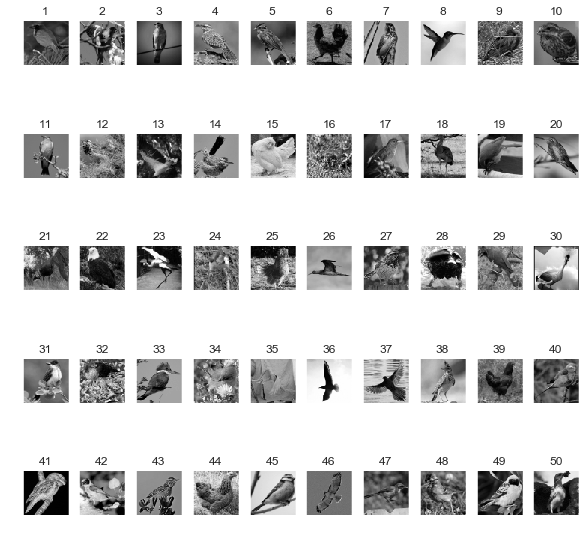

-------------------------------------


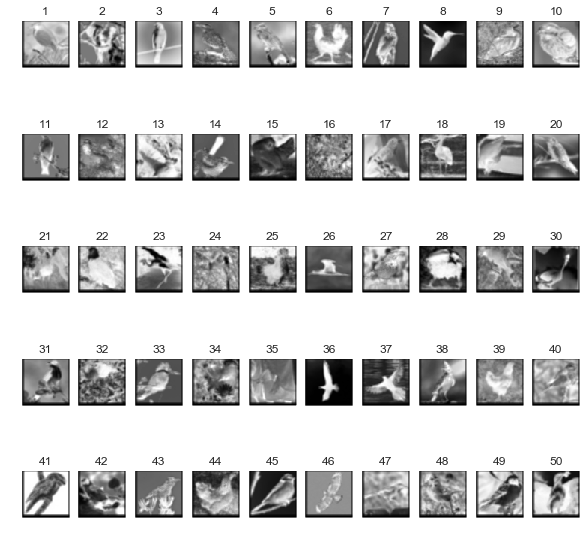

-------------------------------------


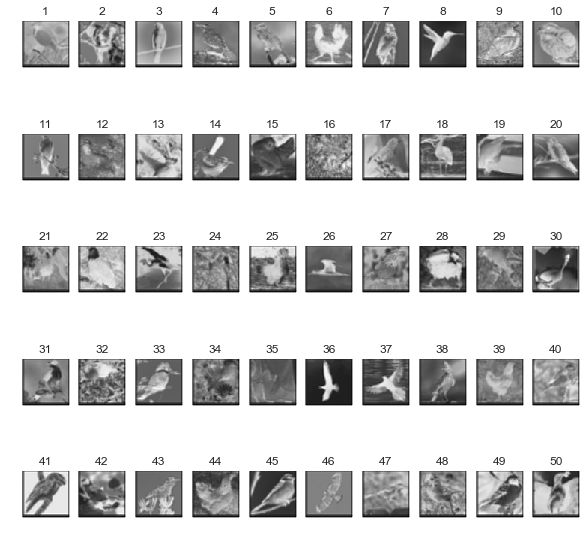

-------------------------------------


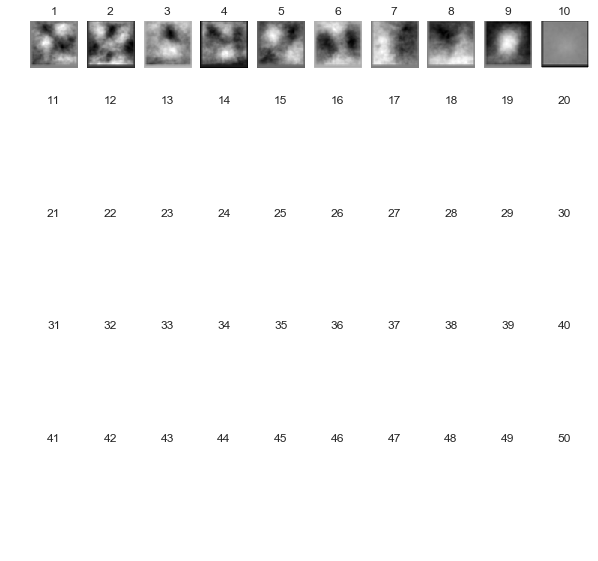

-------------------------------------


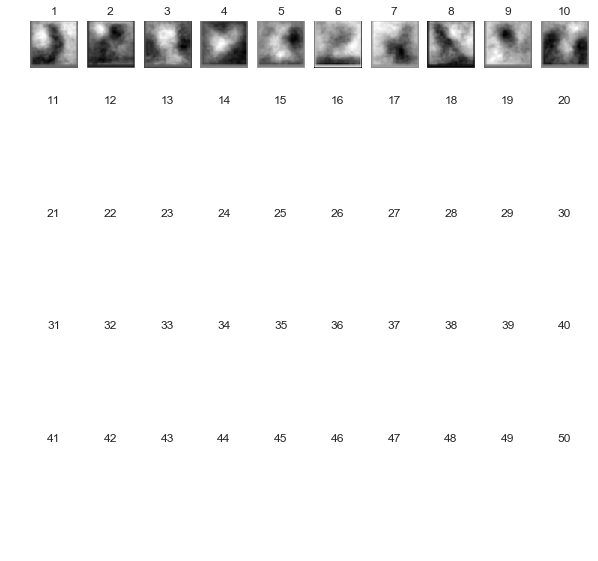

-------------------------------------


In [277]:
# 120 120
fig=plt.figure(figsize=(10, 10))
columns = 10 ; rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(current_data[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

for temp in sess_results:
    fig=plt.figure(figsize=(10, 10))
    columns = 10 ; rows = 5
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        try:
#             plt.imshow(np.squeeze(temp[i-1]).reshape(64,64,3))
            plt.imshow(np.squeeze(temp[i-1]).reshape(64,64),cmap='gray')

        except:
            pass
        plt.axis('off')
        plt.title(str(i))
    plt.show()
    print('-------------------------------------')

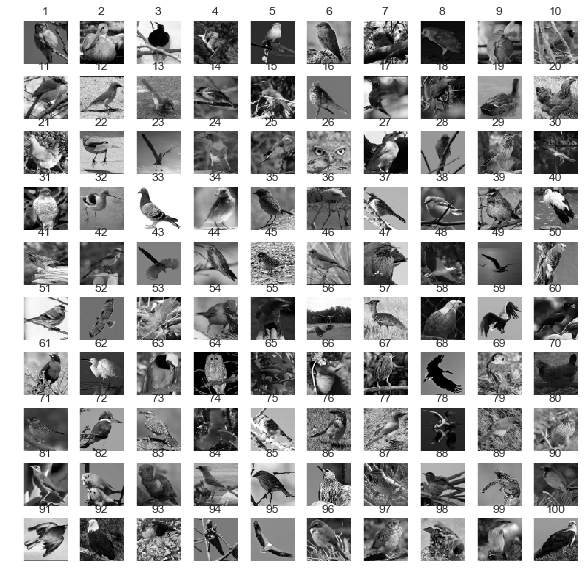

-------------------------------------


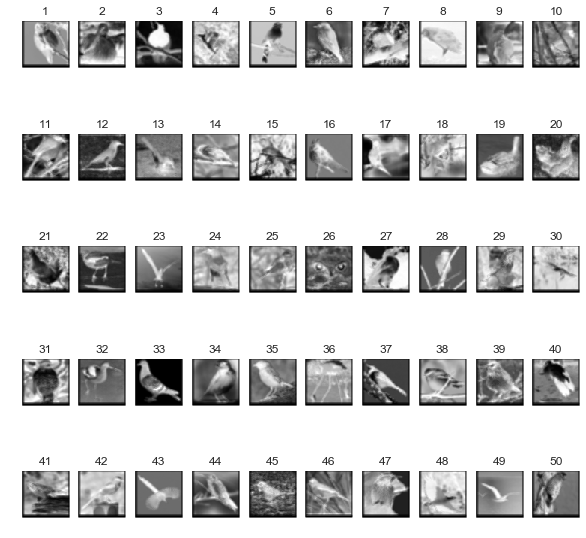

-------------------------------------


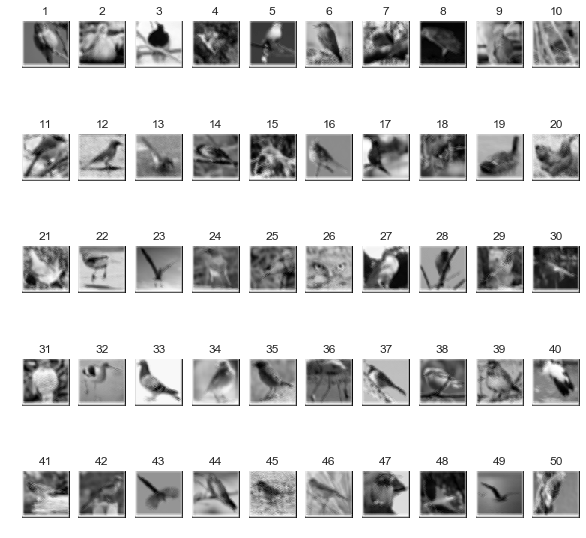

-------------------------------------


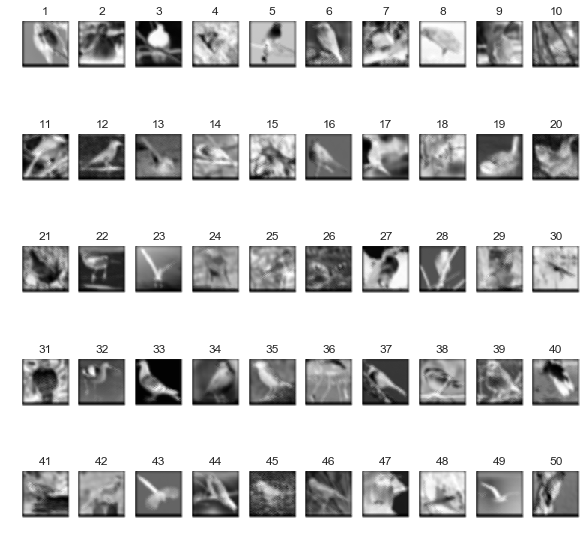

-------------------------------------


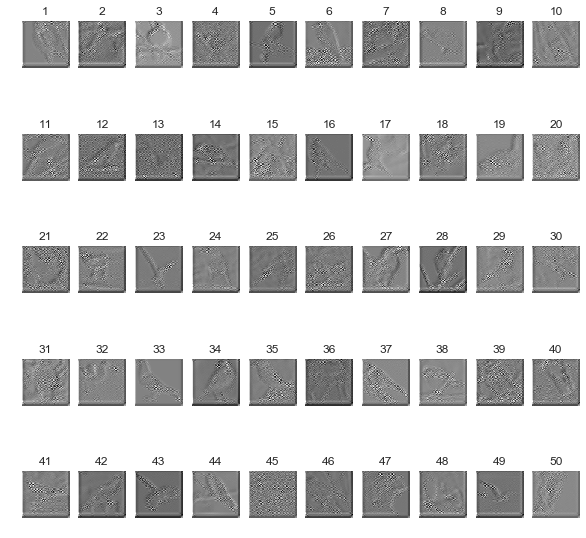

-------------------------------------


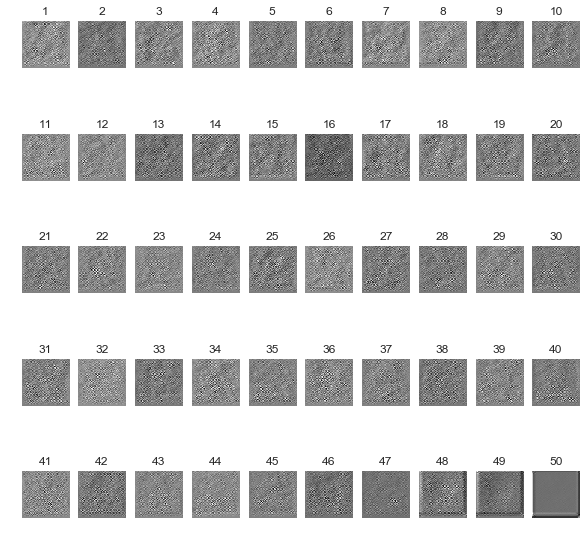

-------------------------------------


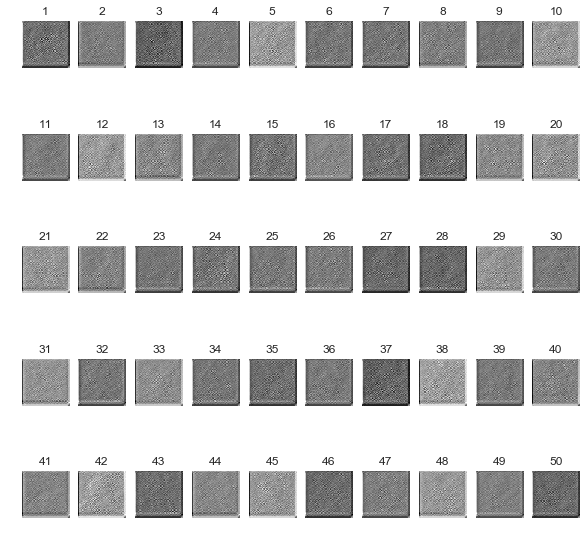

-------------------------------------


In [165]:
# 50 50
fig=plt.figure(figsize=(10, 10))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(current_data[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

for temp in sess_results:
    fig=plt.figure(figsize=(10, 10))
    columns = 10 ; rows = 5
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        try:
            plt.imshow(np.squeeze(temp[i-1]).reshape(64,64),cmap='gray')
        except:
            pass
        plt.axis('off')
        plt.title(str(i))
    plt.show()
    print('-------------------------------------')

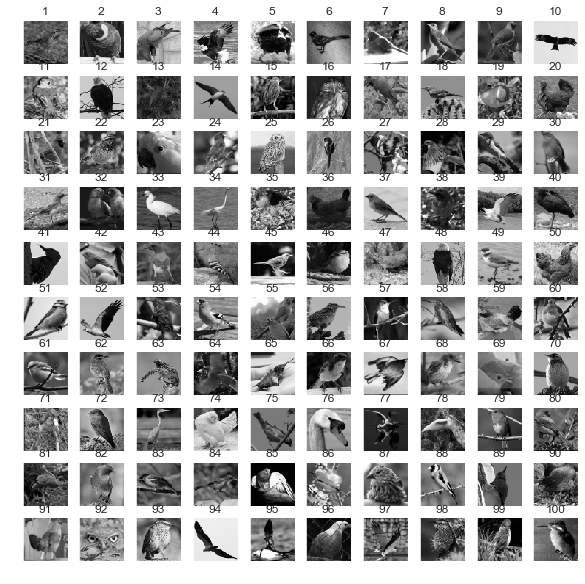

-------------------------------------


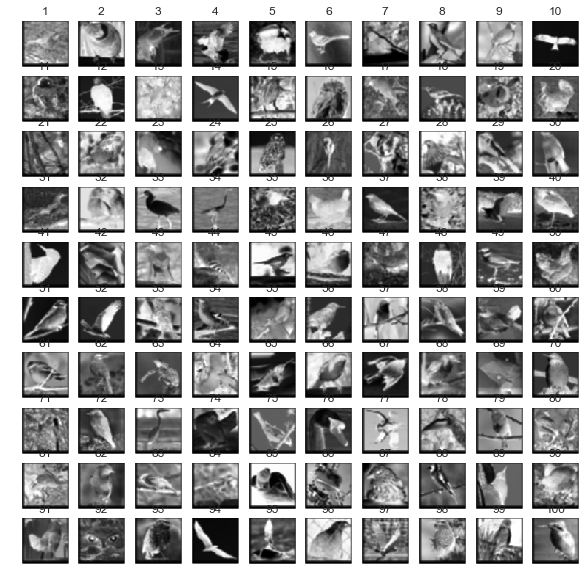

-------------------------------------


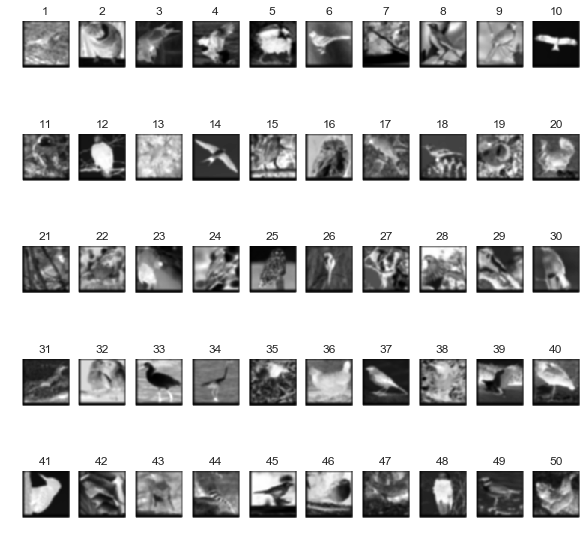

-------------------------------------


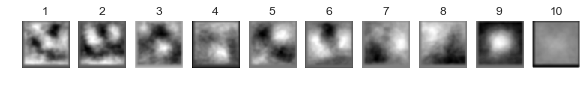

-------------------------------------


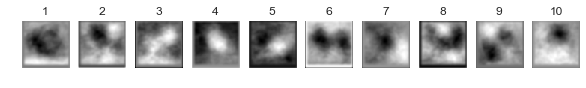

-------------------------------------


In [72]:
# past view

fig=plt.figure(figsize=(10, 10))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(current_data[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

fig=plt.figure(figsize=(10, 10))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(data1[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

fig=plt.figure(figsize=(10, 10))
columns = 10 ; rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(data2[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

fig=plt.figure(figsize=(10, 10))
columns = 10 ; rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(np.squeeze(data_pca[i-1]),cmap='gray')
    except:
        pass
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

fig=plt.figure(figsize=(10, 10))
columns = 10 ; rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(np.squeeze(data_ica[i-1]),cmap='gray')
    except:
        pass
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

(500, 4096)


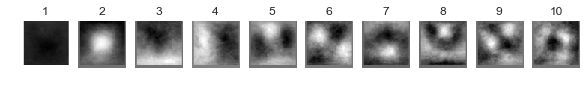

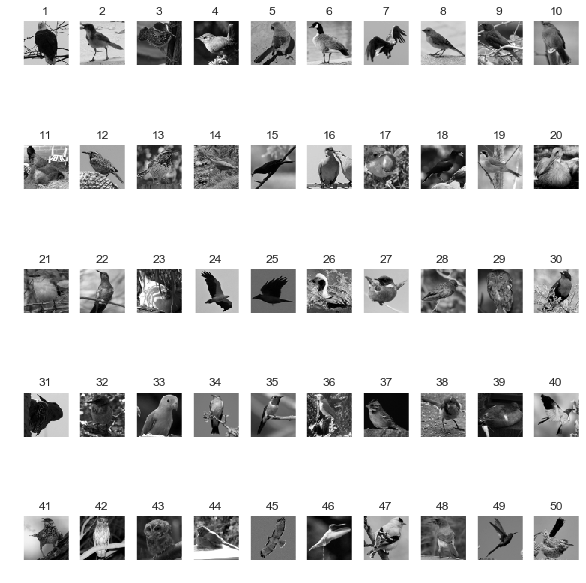

In [104]:
# sk pca
sk_test_data = train_batch.reshape(500,-1)
print(sk_test_data.shape)
from sklearn.decomposition import PCA
sk_pca = PCA(n_components=10)
sk_pca_data = sk_pca.fit_transform(sk_test_data.T).T
sk_pca_data = sk_pca_data.reshape(10,64,64)
fig=plt.figure(figsize=(10, 11))
columns = 10 ; rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(sk_pca_data[i-1],cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()

fig=plt.figure(figsize=(10, 11))
columns = 10 ; rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


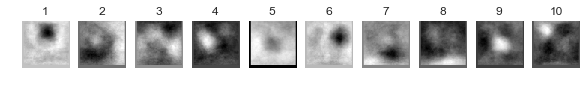

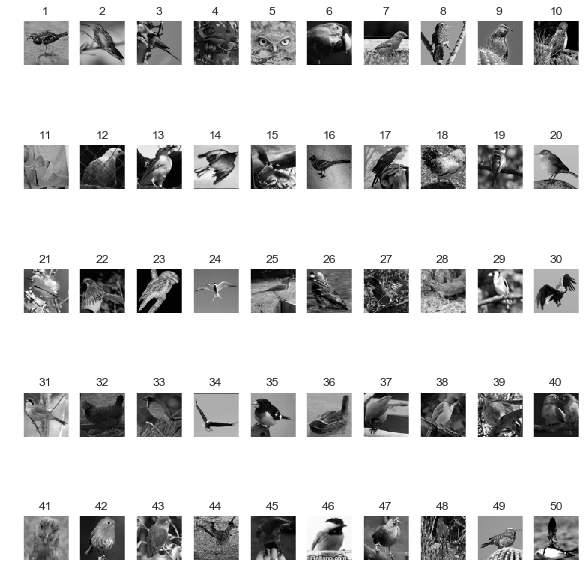

In [113]:
# sk ica
from sklearn.decomposition import FastICA
sk_ica = FastICA(n_components=10)
sk_ica_data = sk_ica.fit_transform(sk_test_data.T).T
sk_ica_data = sk_ica_data.reshape(10,64,64)
fig=plt.figure(figsize=(10, 11))
columns = 10 ; rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(sk_ica_data[i-1],cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()

fig=plt.figure(figsize=(10, 11))
columns = 10 ; rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()